In [24]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from model import IDCD

In [2]:
# 数据加载部分替换为：
def load_math1_data(data_dir='./data'):
    """加载Math1数据集"""
    # 加载训练集（包含user_id, item_id, score三列）
    train_df = pd.read_csv(f'{data_dir}/math1_train_0.8_0.2.csv')

    # 加载验证集（可选）
    valid_df = pd.read_csv(f'{data_dir}/math1_valid_0.8_0.2.csv') if os.path.exists(f'{data_dir}/math1_valid_0.8_0.2.csv') else None

    # 加载Q矩阵
    Q_prior = np.load(f'{data_dir}/best_q_matrix_top1.npy')

    # 统计基本参数
    n_user = train_df['user_id'].max() + 1  # user_id从0开始
    n_item = train_df['item_id'].nunique()
    n_know = Q_prior.shape[1]

    return train_df, valid_df, Q_prior, n_user, n_item, n_know

In [3]:
train_df, valid_df, Q_prior, n_user, n_item, n_know = load_math1_data()

In [31]:
min_item_id = train_df['item_id'].min()
if min_item_id == 1:
    print("题目索引从1开始")
else:
    print(f"题目索引从 {min_item_id} 开始")

题目索引从 0 开始


In [4]:
# 由于题目索引从0开始，所以题目ID：1,5,7,8,9对应的题目是：2,6,8,9,10
sample_user = 0
sample_item = torch.LongTensor([1,5,7,8,9])  # 选择5个不同题目
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class IDCD_Static(IDCD):
    """禁用动态注意力的变体模型"""
    def predict_response(self, theta, psi, Q_batch):
        # 原始无注意力的实现（使用注释掉的代码）
        theta_agg = self.theta_agg_mat(theta * Q_batch)
        psi_agg = self.psi_agg_mat(psi * Q_batch)
        return self.itf(theta_agg, psi_agg)

In [6]:
# 初始化两个模型
model_dynamic = IDCD(
    n_user=n_user, n_item=n_item, n_know=n_know,
    user_dim=32, item_dim=32, Q_mat=Q_prior,
    q_aug='single', device=device
).to(device)

In [7]:
model_static = IDCD_Static(
    n_user=n_user, n_item=n_item, n_know=n_know,
    user_dim=32, item_dim=32, Q_mat=Q_prior,
    q_aug='single', device=device
).to(device)

In [8]:
def get_alpha_values(model, user_id, item_ids):
    """提取注意力权重工具函数"""
    model.eval()
    alphas = []

    # 获取用户特征（维度应为 [1, n_item]）
    user_log = np.zeros((1, model.n_item))  # 初始化全零向量
    user_data = train_df[train_df['user_id'] == user_id]
    for _, row in user_data.iterrows():
        item_id = row['item_id']
        user_log[0, item_id] = (row['score'] - 0.5) * 2  # 根据实际数据处理
    user_log = torch.Tensor(user_log).to(device)

    for item_id in item_ids:
        # 获取题目特征（维度应为 [1, n_user]）
        item_log = np.zeros((1, model.n_user))  # 初始化全零向量
        item_data = train_df[train_df['item_id'] == item_id]
        for _, row in item_data.iterrows():
            user_id = row['user_id']
            item_log[0, user_id] = (row['score'] - 0.5) * 2  # 根据实际数据处理
        item_log = torch.Tensor(item_log).to(device)

        # 前向传播
        with torch.no_grad():
            _ = model(user_log, item_log,
                     torch.LongTensor([user_id]).to(device),
                     torch.LongTensor([item_id]).to(device))

        # 提取alpha值
        if isinstance(model, IDCD):
            if model.knowledge_attn.last_alpha is not None:
                alpha = model.knowledge_attn.last_alpha.cpu().numpy()[0]
            else:
                print("Warning: last_alpha is None. Using uniform distribution.")
                alpha = np.ones(n_know) / n_know
        else:
            alpha = np.ones(n_know) / n_know  # 静态模型均匀分布

        alphas.append(alpha)

    return np.array(alphas)


In [9]:
# Math1数据集中有15个题目
n_item = 15
model = IDCD(
    n_user=4209,
    n_item=n_item,  # 与数据一致
    n_know=11,
    user_dim=32,
    item_dim=32,
    Q_mat=Q_prior,
    q_aug='single',
    device=device
)

In [10]:
# 获取动态模型权重
dynamic_alphas = get_alpha_values(model_dynamic, sample_user, sample_item)

In [11]:
# 获取静态模型权重
static_alphas = get_alpha_values(model_static, sample_user, sample_item)

In [14]:
# 生成知识点标签
knowledge_tags = [f"K{i+1}" for i in range(n_know)]
question_tags = [f"Q{i}" for i in sample_item.numpy()]

Text(220.72222222222223, 0.5, 'Questions')

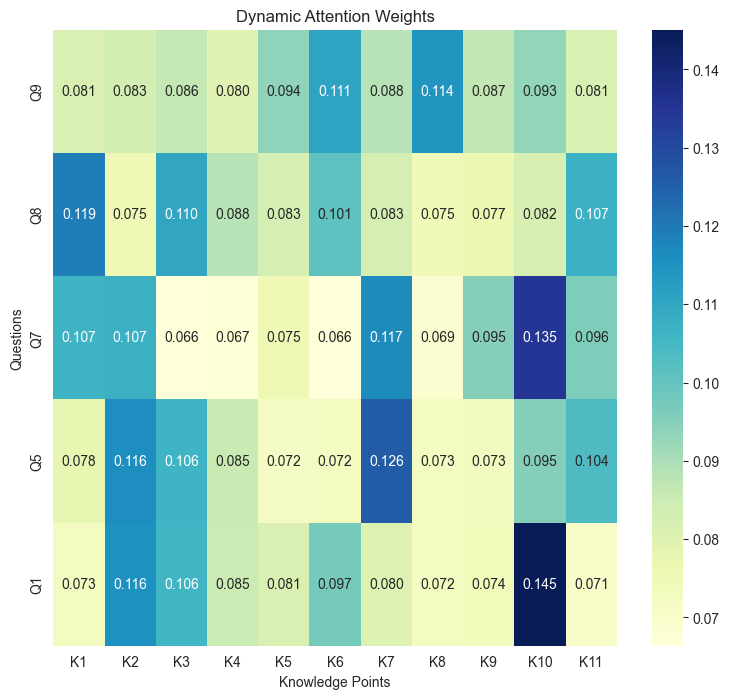

In [21]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
ax = sns.heatmap(
    dynamic_alphas,
    annot=True,
    fmt=".3f",  # 三位小数
    xticklabels=knowledge_tags,
    yticklabels=question_tags,
    cmap="YlGnBu",
    annot_kws={"size": 10}
)
ax.invert_yaxis()  # 反转纵轴
plt.title("Dynamic Attention Weights")
plt.xlabel("Knowledge Points")
plt.ylabel("Questions")

Text(0.5, 58.7222222222222, 'Knowledge Points')

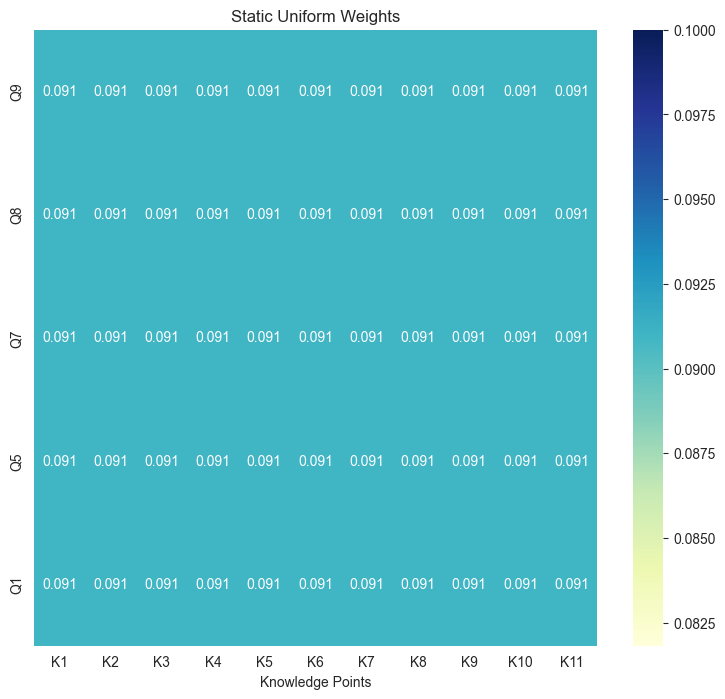

In [22]:
# 静态注意力热力图
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 2)
ax = sns.heatmap(
    static_alphas,
    annot=True,
    fmt=".3f",  # 三位小数
    xticklabels=knowledge_tags,
    yticklabels=question_tags,
    cmap="YlGnBu",
    annot_kws={"size": 10}
)
ax.invert_yaxis()  # 反转纵轴
plt.title("Static Uniform Weights")
plt.xlabel("Knowledge Points")

Text(0.5, 1.0, 'Attention Weight Differences')

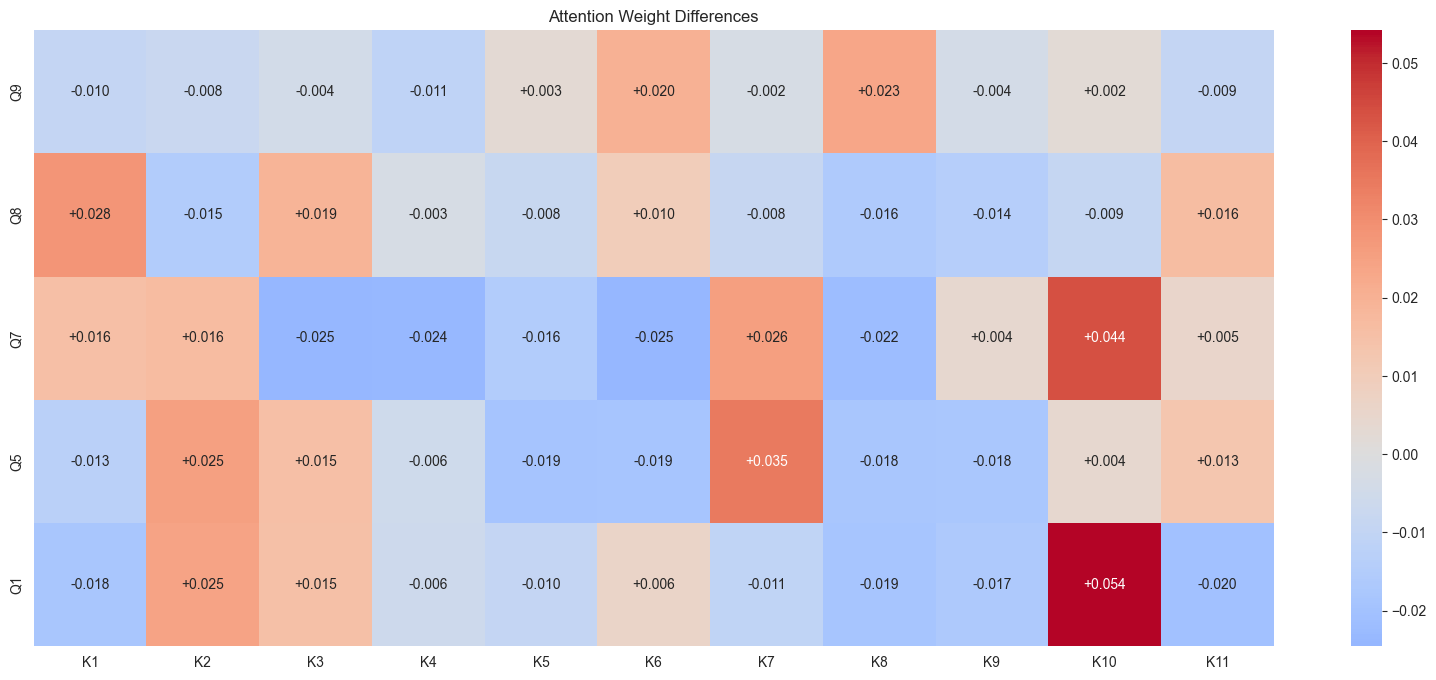

In [23]:
# ## 差异度分析
# %%
delta_matrix = dynamic_alphas - static_alphas

plt.figure(figsize=(20, 8))
ax = sns.heatmap(
    delta_matrix,
    annot=True,
    fmt="+.3f",  # 三位小数带符号
    center=0,
    xticklabels=knowledge_tags,
    yticklabels=question_tags,
    cmap="coolwarm"
)
ax.invert_yaxis()  # 反转纵轴
plt.title("Attention Weight Differences")

In [ ]:
# 第一张图（动态注意力热力图）：展示动态模型（IDCD 模型）在样本用户对不同题目作答时，对各个知识点的注意力权重分布情况。颜色深浅代表权重大小，通过观察可以了解动态模型在不同题目上重点关注哪些知识点 。

# 第二张图（静态注意力热力图）：展示静态模型（IDCD_Static 模型）在样本用户对不同题目作答时，对各个知识点的注意力权重分布。由于静态模型使用均匀分布权重，所以图中数值都相同，这张图可作为对比基准 。

# 第三张图（差异度分析图）：呈现动态模型和静态模型注意力权重的差值，正值表示动态模型对该知识点的权重高于静态模型，负值则相反。通过这张图可以直观地看出动态模型相对静态模型在知识点权重分配上的变化。